# To find the segement for Bar in New York

### Build the required environment 
All of the package would be used in this sequence including numpy, pandas, geopy, matplotlib and folium to manipulate the dataset and add the marker on the map. Package "sklearn" will launch the K-means analysis.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import urllib.request
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Libraries imported.')

Libraries imported.


### Load the map data
Using the public sources to pickout the borough / neighbourhood name.
The address of the resources: https://cocl.us/new_york_dataset.

Create the table of neighourhood and its location information.

In [2]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [4]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Use geopy library to get the latitude and longitude values of New York City

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent ny_explorer, as shown below.

In [5]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### Create a map of New York with neighborhoods superimposed on top

In [6]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [7]:
import folium
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, borough, neighborhood in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Borough'], manhattan_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Foursquare venues
import the data from Foursquare to find out the venues around the Bars in the New York City.

In [8]:
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [9]:
LIMIT = 500 
radius = 5000 
CLIENT_ID = 'SO1VLL3V3U4EXE1YXKWQWJPC1X01P5HUC3DYWCQJVWR3ELFQ'
CLIENT_SECRET = 'NFAZOOPXIQHM24LSRK2RF4SNS5IQGEAV2G4IGQKQ1VY5C530'
VERSION = '20180605'

In [10]:
#https://developer.foursquare.com/docs/resources/categories
#Bar = 4bf58dd8d48988d116941735
neighborhoods = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
newyork_venues_bar = getNearbyVenues(names=neighborhoods['Neighborhood'], latitudes=neighborhoods['Latitude'], longitudes=neighborhoods['Longitude'], radius=1000, categoryIds='4bf58dd8d48988d116941735')
newyork_venues_bar.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Applebee's Grill + Bar,40.873685,-73.908928,American Restaurant
1,Marble Hill,40.876551,-73.91066,235th at Riverdale Ave.,40.885190,-73.907366,Cocktail Bar
2,Marble Hill,40.876551,-73.91066,JOMO'S,40.870203,-73.903531,Whisky Bar
3,Marble Hill,40.876551,-73.91066,Keenan's,40.879208,-73.904567,Bar
4,Marble Hill,40.876551,-73.91066,American Legion Post 774,40.879991,-73.908366,Speakeasy


In [11]:
newyork_venues_bar.shape

(1780, 7)

In [12]:
def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(df['Venue Latitude'], df['Venue Longitude'], df['Neighborhood'], df['Venue'], df['Venue Category']):
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

In [13]:
map_newyork_bar = folium.Map(location=[latitude, longitude], zoom_start=13)
addToMap(newyork_venues_bar, 'red', map_newyork_bar)

map_newyork_bar

In [14]:
def addColumn(startDf, columnTitle, dataDf):
    grouped = dataDf.groupby('Neighborhood').count()
    
    for n in startDf['Neighborhood']:
        try:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = grouped.loc[n, 'Venue']
        except:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = 0

In [15]:
manhattan_grouped = newyork_venues_bar.groupby('Neighborhood').count()
manhattan_grouped
print('There are {} uniques categories.'.format(len(newyork_venues_bar['Venue Category'].unique())))

There are 86 uniques categories.


### Analyze Each Neighborhood
To find out the top 10 venues in each neighorbood and sorted in the ascending order.

In [16]:
manhattan_bar = pd.get_dummies(newyork_venues_bar[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_bar['Neighborhood'] = newyork_venues_bar['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_bar.columns[-1]] + list(manhattan_bar.columns[:-1])
manhattan_bar = manhattan_bar[fixed_columns]

manhattan_bar.head()

,Neighborhood,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bistro,Bookstore,Brazilian Restaurant,Burger Joint,Café,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Cuban Restaurant,Diner,Dive Bar,English Restaurant,Event Space,Flower Shop,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Gastropub,Gay Bar,German Restaurant,Greek Restaurant,Harbor / Marina,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Liquor Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Music Venue,New American Restaurant,Nightclub,Paella Restaurant,Performing Arts Venue,Piano Bar,Pizza Place,Pub,Restaurant,Rock Club,Roof Deck,Sake Bar,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Snack Place,Spanish Restaurant,Speakeasy,Sports Bar,Steakhouse,Strip Club,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tech Startup,Thai Restaurant,Theater,Theme Restaurant,Tiki Bar,Turkish Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop
0,Marble Hill,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Marble Hill,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
manhattan_grouped = manhattan_bar.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,American Restaurant,Arepa Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bistro,Bookstore,Brazilian Restaurant,Burger Joint,Café,Caribbean Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Cuban Restaurant,Diner,Dive Bar,English Restaurant,Event Space,Flower Shop,Food & Drink Shop,French Restaurant,Fried Chicken Joint,Gastropub,Gay Bar,German Restaurant,Greek Restaurant,Harbor / Marina,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Karaoke Bar,Korean Restaurant,Latin American Restaurant,Liquor Store,Lounge,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Music Venue,New American Restaurant,Nightclub,Paella Restaurant,Performing Arts Venue,Piano Bar,Pizza Place,Pub,Restaurant,Rock Club,Roof Deck,Sake Bar,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Snack Place,Spanish Restaurant,Speakeasy,Sports Bar,Steakhouse,Strip Club,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tech Startup,Thai Restaurant,Theater,Theme Restaurant,Tiki Bar,Turkish Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop
0,Battery Park City,0.047619,0.0,0.00,0.00,0.000000,0.238095,0.000000,0.047619,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.095238,0.000000,0.00,0.0,0.00,0.000000,0.0,0.02381,0.0,0.02381,0.047619,0.0,0.00,0.000000,0.00,0.0,0.0,0.000000,0.02381,0.190476,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.02381,0.0,0.0,0.00,0.02381,0.000000,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.02381,0.02381,0.00,0.0,0.00,0.00,0.0,0.00,0.02381,0.0,0.00,0.00,0.02381,0.02381,0.02381,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.071429,0.00
1,Carnegie Hill,0.040000,0.0,0.00,0.00,0.000000,0.260000,0.000000,0.000000,0.02,0.00,0.00,0.0,0.0,0.00,0.02,0.0,0.0,0.100000,0.040000,0.00,0.0,0.02,0.000000,0.0,0.00000,0.0,0.00000,0.020000,0.0,0.02,0.020000,0.02,0.0,0.0,0.000000,0.00000,0.000000,0.02,0.02,0.0,0.02,0.00,0.0,0.02,0.00000,0.0,0.0,0.02,0.00000,0.000000,0.0,0.0,0.04,0.00,0.00,0.0,0.02,0.00000,0.08000,0.00,0.0,0.00,0.00,0.0,0.02,0.00000,0.0,0.00,0.00,0.06000,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.080000,0.02
2,Central Harlem,0.066667,0.0,0.00,0.00,0.033333,0.366667,0.033333,0.000000,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.233333,0.033333,0.00,0.0,0.00,0.033333,0.0,0.00000,0.0,0.00000,0.000000,0.0,0.00,0.033333,0.00,0.0,0.0,0.033333,0.00000,0.033333,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00000,0.0,0.0,0.00,0.00000,0.033333,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00000,0.00000,0.00,0.0,0.00,0.00,0.0,0.00,0.00000,0.0,0.00,0.00,0.00000,0.00000,0.00000,0.0,0.0,0.066667,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.00
3,Chelsea,0.040000,0.0,0.00,0.00,0.000000,0.100000,0.040000,0.020000,0.00,0.02,0.02,0.0,0.0,0.02,0.00,0.0,0.0,0.100000,0.040000,0.02,0.0,0.00,0.000000,0.0,0.00000,0.0,0.00000,0.020000,0.0,0.00,0.020000,0.00,0.0,0.0,0.000000,0.00000,0.040000,0.00,0.00,0.0,0.00,0.00,0.0,0.02,0.02000,0.0,0.0,0.02,0.00000,0.020000,0.0,0.0,0.02,0.02,0.02,0.0,0.02,0.00000,0.00000,0.00,0.0,0.02,0.00,0.0,0.00,0.00000,0.0,0.02,0.04,0.00000,0.00000,0.00000,0.0,0.0,0.020000,0.0,0.02,0.0,0.0,0.0,0.0,0.00,0.0,0.02,0.200000,0.00
4,Chinatown,0.020000,0.0,0.04,0.02,0.000000,0.120000,0.020000,0.000000,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.260000,0.000000,0.00,0.0,0.00,0.000000,0.0,0.00000,0.0,0.00000,0.000000,0.0,0.00,0.000000,0.00,0.0,0.0,0.000000,0.02000,0.040000,0.00,0.00,0.0,0.02,0.02,0.0,0.02,0.00000,0.0,0.0,0.04,0.02000,0.040000,0.0,0.0,0.04,0.00,0.00,0.0,0.00,0.00000,0.00000,0.02,0.0,0.02,0.02,0.0,0.00,0.00000,0.0,0.00,0.08,0.00000,0.00000,0.00000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.02,0.0,0.02,0.080000,0.00


In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Bar,Hotel Bar,Cocktail Bar,Wine Bar,French Restaurant,Beer Garden,American Restaurant,Pub,Steakhouse,Event Space
1,Carnegie Hill,Bar,Cocktail Bar,Wine Bar,Pub,Sports Bar,American Restaurant,New American Restaurant,Coffee Shop,Indian Restaurant,Lounge
2,Central Harlem,Bar,Cocktail Bar,American Restaurant,Tapas Restaurant,Hotel Bar,Coffee Shop,Gay Bar,Hookah Bar,Mexican Restaurant,Beer Bar
3,Chelsea,Wine Bar,Bar,Cocktail Bar,American Restaurant,Hotel Bar,Speakeasy,Beer Bar,Coffee Shop,Piano Bar,Tech Startup
4,Chinatown,Cocktail Bar,Bar,Wine Bar,Speakeasy,Hotel Bar,Asian Restaurant,Lounge,Mexican Restaurant,New American Restaurant,Italian Restaurant


In [20]:
df_new = pd.DataFrame()
for i in [3,2,1]:
    df_new[i] = neighborhoods_venues_sorted.iloc[:,i].value_counts()

df_new.fillna(0, inplace=True)
df_new.columns=['3rd Common','2nd Common','1st Common']

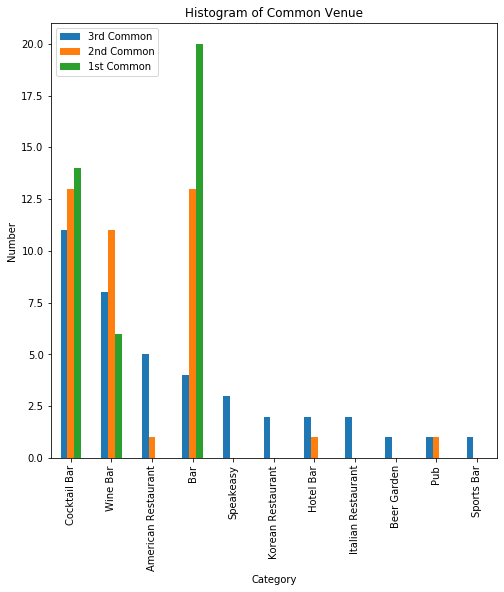

In [21]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)

df_new.plot(ax = ax1, kind='bar')

plt.xlabel('Category')

ax1.set_ylabel('Number')

plt.legend(loc = 2)

plt.title('Histogram of Common Venue')

plt.show()

### Cluster Neighborhoods

In [22]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 2, 0, 3, 3, 0, 2, 3, 1], dtype=int32)

In [23]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,2,Bar,Pub,Cocktail Bar,American Restaurant,Whisky Bar,Hotel Bar,Speakeasy,Café,Fried Chicken Joint,Event Space
1,Manhattan,Chinatown,40.715618,-73.994279,3,Cocktail Bar,Bar,Wine Bar,Speakeasy,Hotel Bar,Asian Restaurant,Lounge,Mexican Restaurant,New American Restaurant,Italian Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,2,Bar,Cocktail Bar,Speakeasy,Mexican Restaurant,Lounge,Café,Sports Bar,Dive Bar,Tapas Restaurant,Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,2,Bar,Wine Bar,Cocktail Bar,Pub,Café,Beer Garden,Lounge,Tapas Restaurant,Sports Bar,Mexican Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,2,Bar,Cocktail Bar,Wine Bar,Gay Bar,Pub,Dive Bar,Speakeasy,Tapas Restaurant,Coffee Shop,Lounge


In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [25]:
def graph(df):
    df_new1 = pd.DataFrame()
    df_new1 = df.iloc[:,1].value_counts()
    df_new1.columns = ['1st Common']
    df_new2 = pd.DataFrame()
    df_new2 = df.iloc[:,2].value_counts()
    df_new2.columns = ['2nd Common']
    df_new3 = pd.DataFrame()
    df_new3 = df.iloc[:,3].value_counts()
    df_new3.columns = ['3rd Common']   

    df_new = pd.merge(pd.merge(df_new1, df_new2, left_index=True, right_index=True, how='outer'),df_new3, left_index=True, right_index=True, how='outer')
    df_new.fillna(0, inplace=True)
    
    fig = plt.figure(figsize=(8,8))
    ax1 = fig.add_subplot(111)

    df_new.plot(ax = ax1, kind='bar')

    plt.xlabel('Category')

    ax1.set_ylabel('Number')

    plt.legend(loc = 2)

    plt.title('Histogram of Common Venue')

    plt.show()
    return plt.show()

In [26]:
df_0 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
df_0

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Upper West Side,Wine Bar,Bar,Pub,Dive Bar,Italian Restaurant,Karaoke Bar,Cocktail Bar,Speakeasy,Sports Bar,American Restaurant
13,Lincoln Square,Wine Bar,Bar,American Restaurant,Lounge,Cocktail Bar,Italian Restaurant,Gay Bar,Mexican Restaurant,Pub,Café
14,Clinton,Bar,Wine Bar,Cocktail Bar,New American Restaurant,American Restaurant,Dive Bar,Gay Bar,Italian Restaurant,Gastropub,Coffee Shop
17,Chelsea,Wine Bar,Bar,Cocktail Bar,American Restaurant,Hotel Bar,Speakeasy,Beer Bar,Coffee Shop,Piano Bar,Tech Startup
34,Sutton Place,Wine Bar,Bar,Cocktail Bar,Restaurant,American Restaurant,French Restaurant,Speakeasy,Hotel Bar,Beer Garden,Beer Bar
35,Turtle Bay,Wine Bar,Bar,Cocktail Bar,Restaurant,Pub,Seafood Restaurant,Karaoke Bar,American Restaurant,French Restaurant,Coffee Shop
36,Tudor City,Bar,Wine Bar,Cocktail Bar,Pub,American Restaurant,Lounge,Seafood Restaurant,Karaoke Bar,German Restaurant,Latin American Restaurant
39,Hudson Yards,Bar,American Restaurant,Cocktail Bar,Lounge,Hotel Bar,New American Restaurant,Sports Bar,Wine Bar,Italian Restaurant,Pub


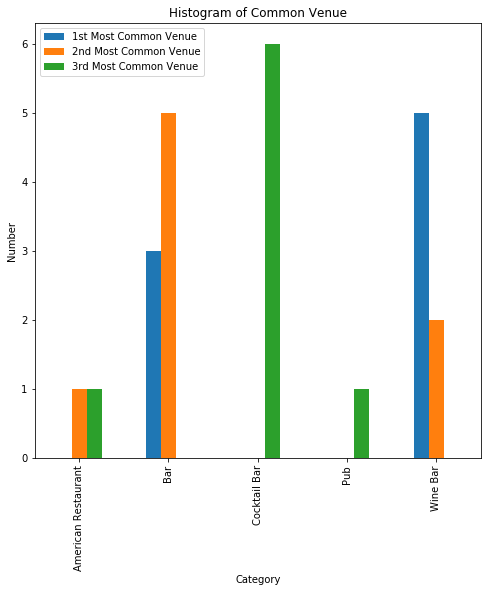

In [27]:
graph(df_0)

In [28]:
df_1 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
df_1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Manhattanville,Bar,Cocktail Bar,American Restaurant,Wine Bar,Pub,Sports Bar,BBQ Joint,Cuban Restaurant,Dive Bar,Hotel Bar
10,Lenox Hill,Cocktail Bar,Bar,Wine Bar,Beer Garden,Gastropub,Pub,Hotel Bar,Burger Joint,American Restaurant,Thai Restaurant
15,Midtown,Cocktail Bar,Bar,Korean Restaurant,Italian Restaurant,Hotel Bar,Wine Bar,Speakeasy,Lounge,Japanese Restaurant,Restaurant
16,Murray Hill,Cocktail Bar,Bar,Korean Restaurant,Hotel Bar,Wine Bar,American Restaurant,Karaoke Bar,Lounge,Pub,Speakeasy
27,Gramercy,Bar,Cocktail Bar,American Restaurant,Wine Bar,Pub,Speakeasy,Roof Deck,Comedy Club,Hotel Bar,Lounge
28,Battery Park City,Bar,Hotel Bar,Cocktail Bar,Wine Bar,French Restaurant,Beer Garden,American Restaurant,Pub,Steakhouse,Event Space
29,Financial District,Bar,Cocktail Bar,Hotel Bar,Restaurant,Mexican Restaurant,Wine Bar,Wine Shop,Pub,Pizza Place,Mediterranean Restaurant
33,Midtown South,Cocktail Bar,Bar,Hotel Bar,Speakeasy,Wine Bar,Korean Restaurant,Lounge,American Restaurant,Japanese Restaurant,Comedy Club
38,Flatiron,Cocktail Bar,Bar,American Restaurant,Wine Bar,Hotel Bar,Speakeasy,Tapas Restaurant,Steakhouse,Comedy Club,Beer Bar


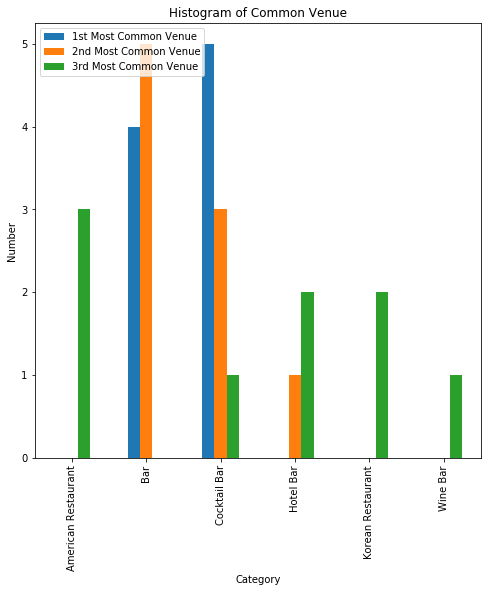

In [29]:
graph(df_1)

In [30]:
df_2 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
df_2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Bar,Pub,Cocktail Bar,American Restaurant,Whisky Bar,Hotel Bar,Speakeasy,Café,Fried Chicken Joint,Event Space
2,Washington Heights,Bar,Cocktail Bar,Speakeasy,Mexican Restaurant,Lounge,Café,Sports Bar,Dive Bar,Tapas Restaurant,Restaurant
3,Inwood,Bar,Wine Bar,Cocktail Bar,Pub,Café,Beer Garden,Lounge,Tapas Restaurant,Sports Bar,Mexican Restaurant
4,Hamilton Heights,Bar,Cocktail Bar,Wine Bar,Gay Bar,Pub,Dive Bar,Speakeasy,Tapas Restaurant,Coffee Shop,Lounge
6,Central Harlem,Bar,Cocktail Bar,American Restaurant,Tapas Restaurant,Hotel Bar,Coffee Shop,Gay Bar,Hookah Bar,Mexican Restaurant,Beer Bar
7,East Harlem,Bar,Cocktail Bar,Speakeasy,Beer Bar,Hookah Bar,American Restaurant,Gastropub,Pub,New American Restaurant,Steakhouse
8,Upper East Side,Bar,Cocktail Bar,Sports Bar,New American Restaurant,Burger Joint,Pub,Café,Wine Bar,Italian Restaurant,Gastropub
9,Yorkville,Bar,Cocktail Bar,Wine Bar,Pub,American Restaurant,Coffee Shop,French Restaurant,Restaurant,Piano Bar,English Restaurant
11,Roosevelt Island,Bar,Cocktail Bar,Beer Garden,Pub,Speakeasy,Wine Bar,Wine Shop,Latin American Restaurant,Sports Bar,Steakhouse
25,Manhattan Valley,Bar,Wine Bar,Cocktail Bar,Karaoke Bar,Speakeasy,Sports Bar,Gay Bar,Mexican Restaurant,Burger Joint,Gastropub


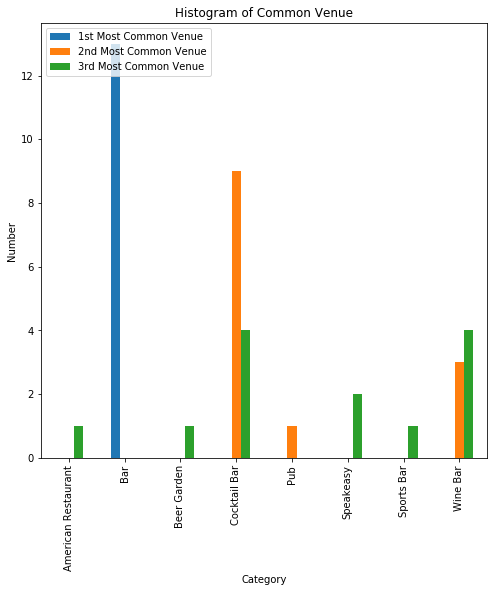

In [31]:
graph(df_2)

In [32]:
df_3 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
df_3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Cocktail Bar,Bar,Wine Bar,Speakeasy,Hotel Bar,Asian Restaurant,Lounge,Mexican Restaurant,New American Restaurant,Italian Restaurant
19,East Village,Cocktail Bar,Wine Bar,Bar,Speakeasy,Sake Bar,Beer Bar,Japanese Restaurant,Pub,Café,Seafood Restaurant
20,Lower East Side,Cocktail Bar,Bar,Wine Bar,Speakeasy,New American Restaurant,Sake Bar,Beer Bar,Japanese Restaurant,American Restaurant,Dive Bar
21,Tribeca,Cocktail Bar,Bar,Wine Bar,Italian Restaurant,Hotel,Lounge,Hotel Bar,American Restaurant,French Restaurant,Burger Joint
22,Little Italy,Cocktail Bar,Wine Bar,Bar,New American Restaurant,American Restaurant,Hotel Bar,Beer Bar,Japanese Restaurant,Asian Restaurant,Whisky Bar
31,Noho,Cocktail Bar,Wine Bar,Bar,Beer Bar,Sake Bar,Speakeasy,American Restaurant,Café,Hotel,Italian Restaurant
32,Civic Center,Cocktail Bar,Wine Bar,Bar,Hotel Bar,American Restaurant,French Restaurant,Lounge,Karaoke Bar,Hotel,Burger Joint


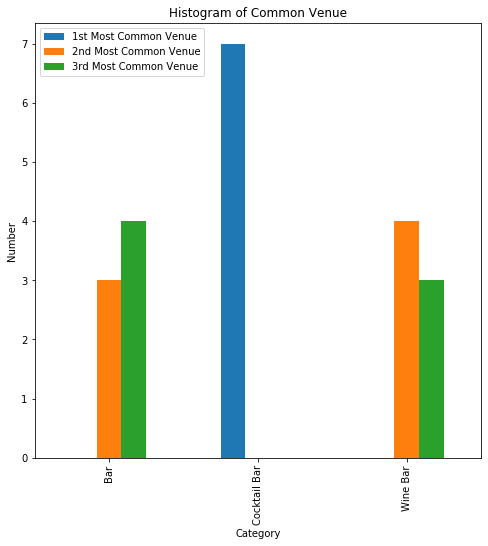

In [33]:
graph(df_3)

In [34]:
df_4 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
df_4

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Greenwich Village,Cocktail Bar,Wine Bar,Speakeasy,Italian Restaurant,New American Restaurant,Jazz Club,Café,Hotel,Pub,Pizza Place
23,Soho,Cocktail Bar,Wine Bar,Italian Restaurant,Bar,Hotel,Whisky Bar,New American Restaurant,Speakeasy,Pub,Lounge
24,West Village,Wine Bar,Cocktail Bar,Italian Restaurant,New American Restaurant,Bar,Speakeasy,Jazz Club,Café,Beer Bar,Tapas Restaurant


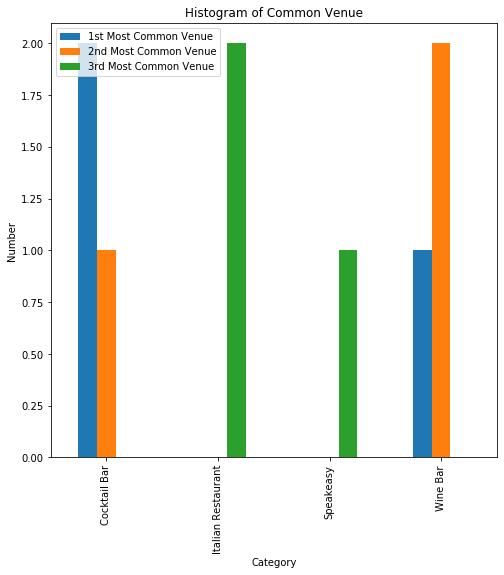

In [35]:
graph(df_4)